In [164]:
import numpy as np
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import openai
import os

In [165]:
with open('stopwords.txt') as f:
    stopwords = f.read().replace('\n',' ').split()

In [166]:
with open('masculine.txt', 'w') as file: 
    pass 
with open('feminine.txt', 'w') as file: 
    pass 
with open('check.txt', 'w') as file: 
    pass 

with open('training_text.txt', encoding='utf-8') as f:
    text = f.read().replace('\n','')
    print(text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([t for t in text if t not in list('0123456789')])
    text = text.replace('”', '').replace('“', '').replace('’', '').lower().split()

text = [w for w in text if w not in stopwords][:2000]

Analyze the following text for words representative of men and women : Word embeddings are a powerful machine-learning framework that represents each English word by a vector. The geometric relationship between these vectors captures meaningful semantic relationships between the corresponding words. In this paper, we develop a framework to demonstrate how the temporal dynamics of the embedding helps to quantify changes in stereotypes and attitudes toward women and ethnic minorities in the 20th and 21st centuries in the United States. We integrate word embeddings trained on 100 y of text data with the US Census to show that changes in the embedding track closely with demographic and occupation shifts over time. The embedding captures societal shifts—e.g., the women’s movement in the 1960s and Asian immigration into the United States—and also illuminates how specific adjectives and occupations became more closely associated with certain populations over time. Our framework for temporal a

In [167]:
WINDOW_SIZE = 3
NUM_NEGATIVE_SAMPLES = 3

data = []

#iterate over all words
for idx,center_word in enumerate(text[WINDOW_SIZE-1:-WINDOW_SIZE]):
    
    #iterate over the context words around the center word
    context_words = [context_word for context_word in text[idx:idx+2*WINDOW_SIZE-1] if context_word != center_word]
    for context_word in context_words:
        
        #get words NOT in the current context as negative examples
        data.append([center_word, context_word, 1])
        negative_samples = np.random.choice([w for w in text[WINDOW_SIZE-1:-WINDOW_SIZE] if w != center_word and w not in context_words], NUM_NEGATIVE_SAMPLES)
        
        for negative_samp in negative_samples:
            
            #add a training row
            data.append([center_word, negative_samp, 0])

In [168]:
df = pd.DataFrame(columns=['center_word', 'context_word', 'label'], data=data)
words = np.intersect1d(df.context_word, df.center_word)
df = df[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)

In [169]:
def sigmoid(v, scale=1):
    return 1 / (1 + np.exp(-scale*v))

In [170]:
def update_embeddings(df, main_embeddings, context_embeddings, learning_rate, debug=False):
    
    #get differences between main embeddings and corresponding context embeddings
    main_embeddings_center = main_embeddings.loc[df.center_word].values
    context_embeddings_context = context_embeddings.loc[df.context_word].values
    diffs = context_embeddings_context - main_embeddings_center
    
    #get similarities, scores, and errors between main embeddings and corresponding context embeddings
    dot_prods = np.sum(main_embeddings_center * context_embeddings_context, axis=1)
    scores = sigmoid(dot_prods)
    errors = (df.label - scores).values.reshape(-1,1)
    
    #calculate updates
    updates = diffs*errors*learning_rate
    updates_df = pd.DataFrame(data=updates)
    updates_df['center_word'] = df.center_word
    updates_df['context_word'] = df.context_word
    updates_df_center = updates_df.groupby('center_word').sum()
    updates_df_context = updates_df.groupby('context_word').sum()
    
    if debug:
        plot_words(debug)
    
    #apply updates
    main_embeddings += updates_df_center.loc[main_embeddings.index]
    context_embeddings -= updates_df_context.loc[context_embeddings.index]
    
    #normalize embeddings
    main_embeddings = normalize_data(main_embeddings)
    context_embeddings = normalize_data(context_embeddings)
    
    #return the updated embeddings
    return main_embeddings, context_embeddings

In [171]:
def normalize_data(data):
    row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
    return data.divide(row_norms, axis='index')

In [172]:
def plot_words(debug):
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,2,1)
    lim_main_first = main_embeddings.loc[[debug[0]]]
    lim_main_second = main_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], main_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    ###################################
    plt.subplot(1,2,2)
    lim_main = main_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_context.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    plt.show()

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

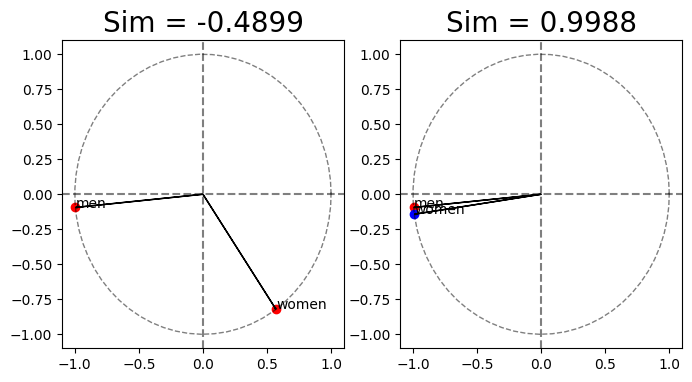

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

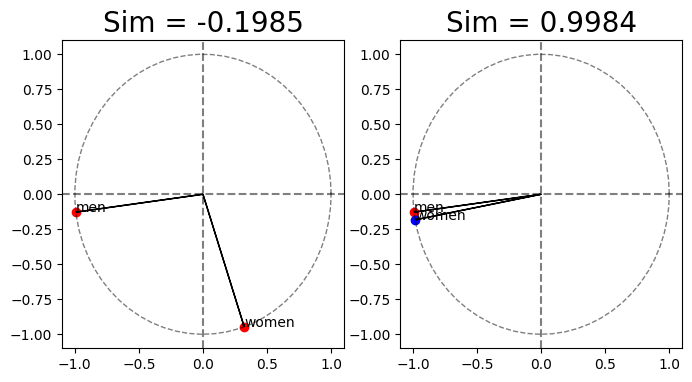

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

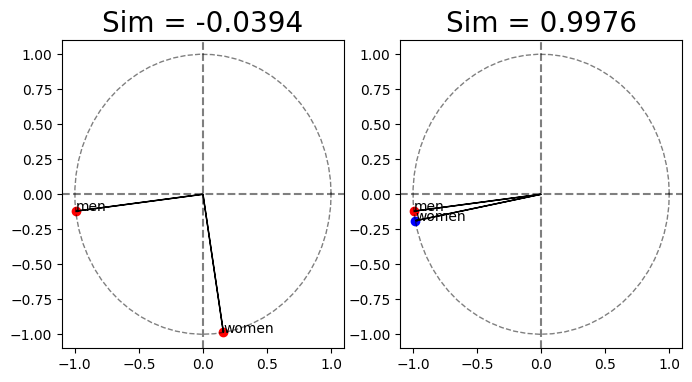

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

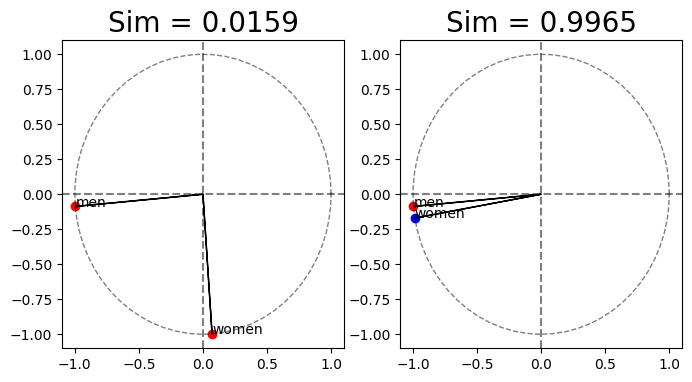

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

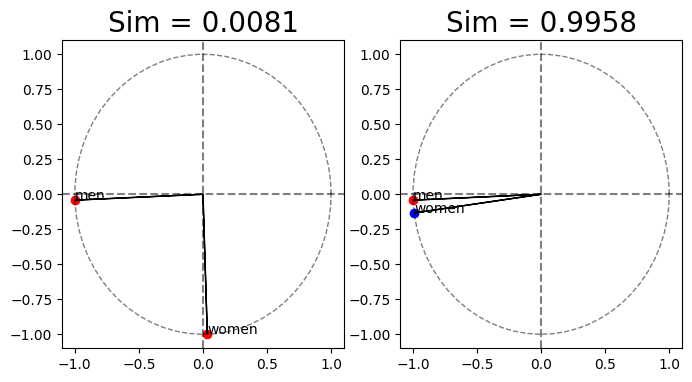

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

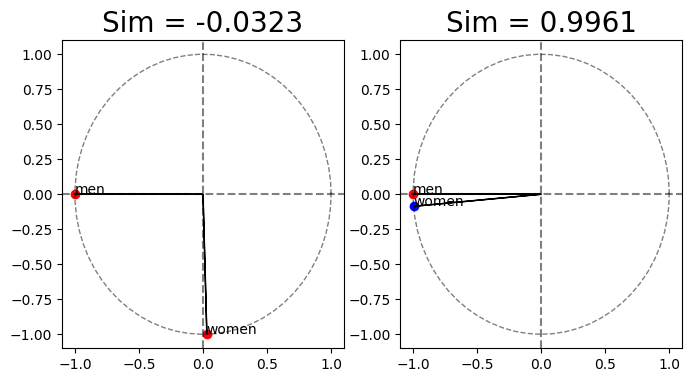

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

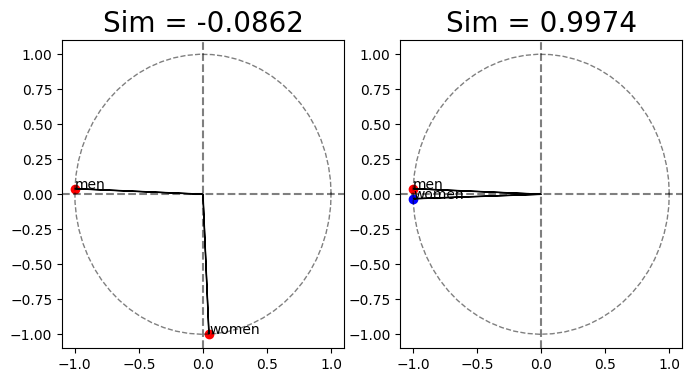

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

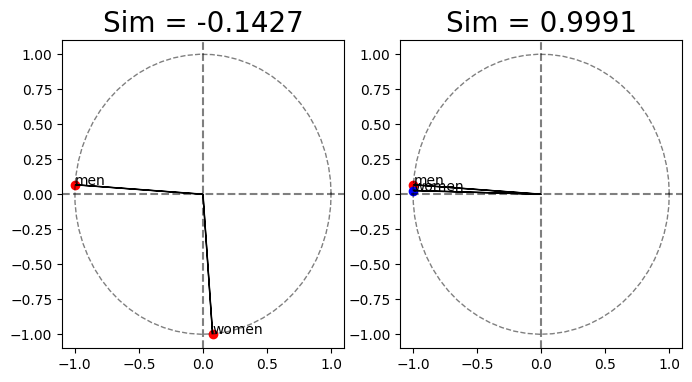

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

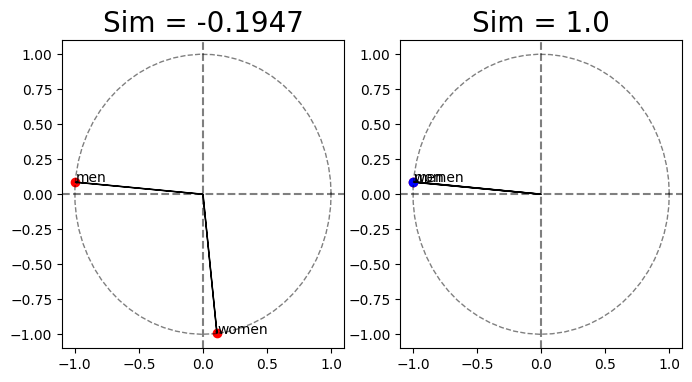

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

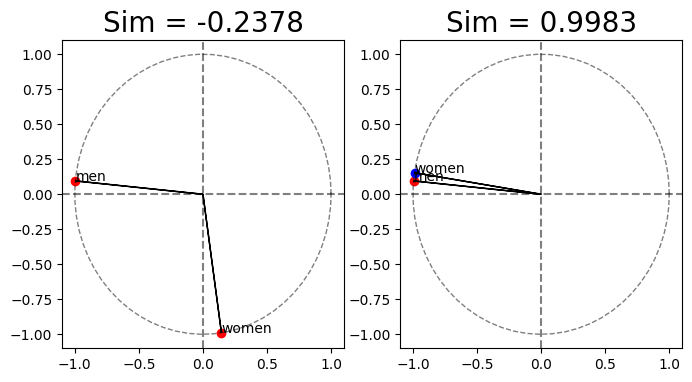

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

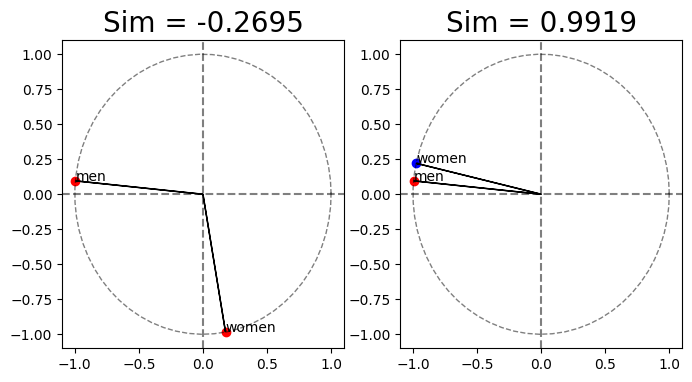

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

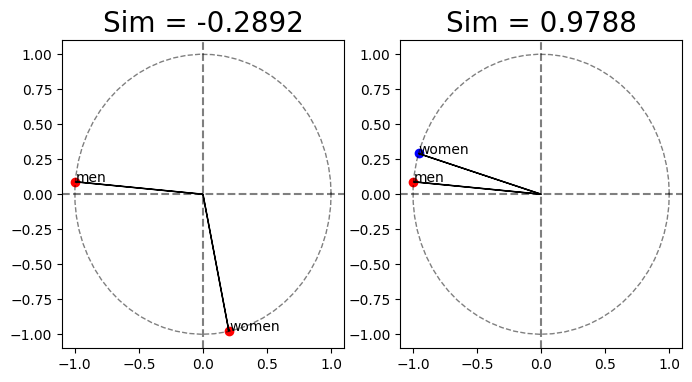

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

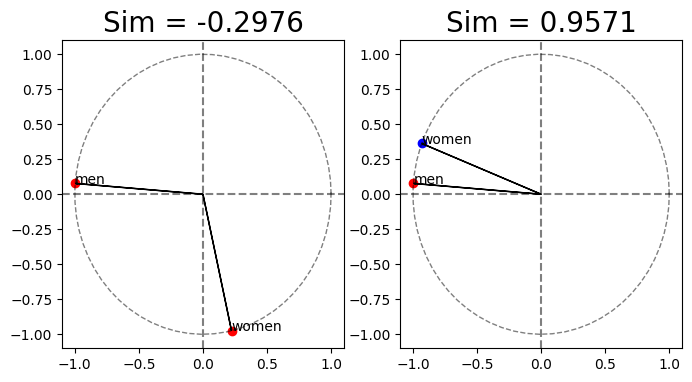

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

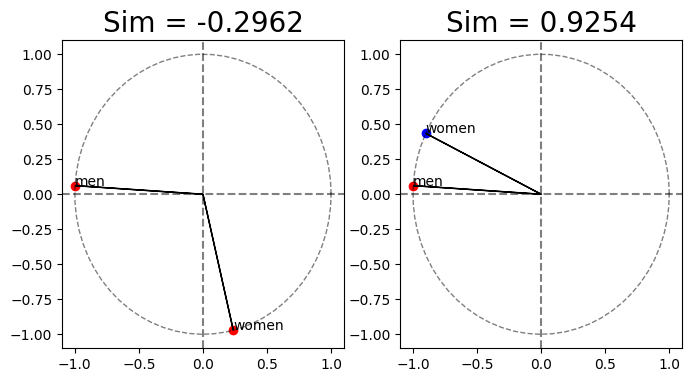

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

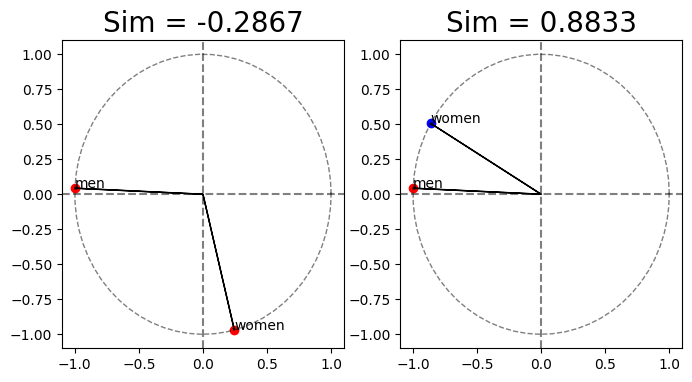

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

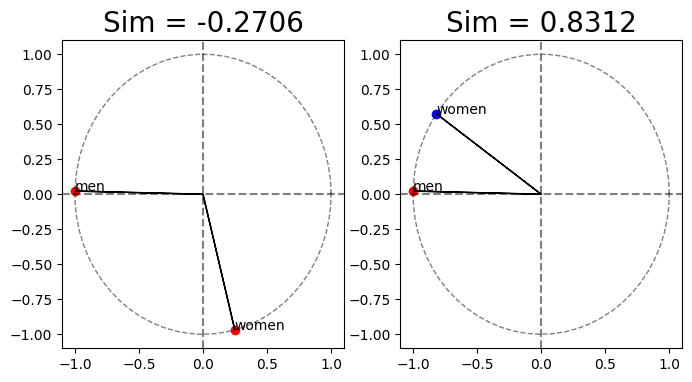

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

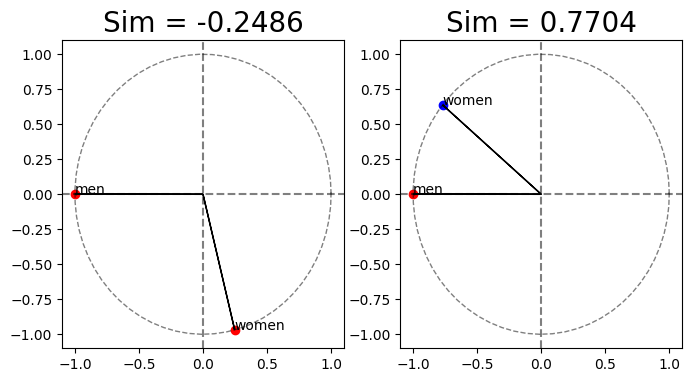

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

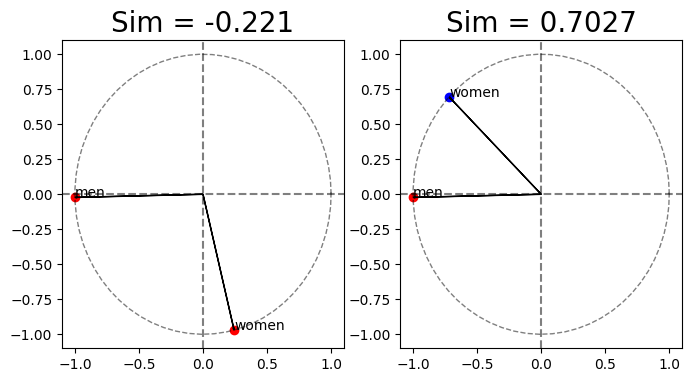

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

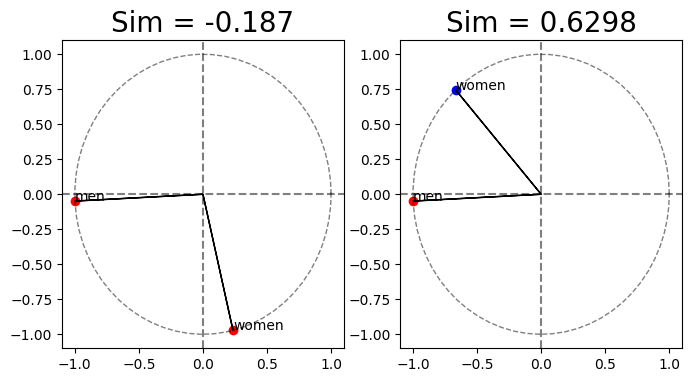

C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\2419458146.py:28: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
C:\Users\Ray\AppData\Local\Temp\ipykernel_15824\

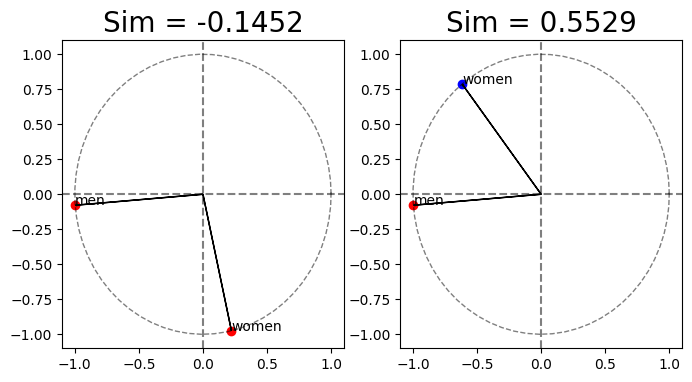

In [173]:
EMBEDDING_SIZE = 2

main_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((main_embeddings**2).sum(axis=1)).reshape(-1,1)
main_embeddings = main_embeddings / row_norms

context_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((context_embeddings**2).sum(axis=1)).reshape(-1,1)
context_embeddings = context_embeddings / row_norms

main_embeddings = pd.DataFrame(data=main_embeddings, index=words)
context_embeddings = pd.DataFrame(data=context_embeddings, index=words)

for _ in range(20):
    main_embeddings, context_embeddings = update_embeddings(df, main_embeddings, context_embeddings, 0.1, ['men', 'women'])

In [174]:
file = open('check.txt', 'a')

#avoid words with numbers followed by measurment units (ie. 100y, 5d, 10cm, etc)
for word in words:
    sim = 1 - cosine(main_embeddings.loc['men'], main_embeddings.loc[word])
    if word != 'men' and word != 'women':
        if (round(sim, 2)) >= 0.25 or (round(sim, 2)) <= -0.25:
            file.write(word + "\n")

for word in words:
    sim = 1 - cosine(main_embeddings.loc['women'], main_embeddings.loc[word])
    if word != 'men' and word != 'women':
        if (round(sim, 2)) >= 0.25 or (round(sim, 2)) <= -0.25:
            file.write(word + "\n")

file.close()

In [175]:
def chat_with_gpt(prompt):
                response = openai.ChatCompletion.create(
                model = "gpt-4-turbo",
                messages = [{"role": "user", "content": prompt}]
                )
                return response.choices[0].message.content.strip()
file = open('check.txt')
for line in file:
    if __name__ == "__main__":
        if line != 'men' and line != 'women':
            response = chat_with_gpt("Is the bare word " + line + " regardless of context, more representative of men or women? Give a one word answer.")
            print(response)
            if response.lower()[0] == "m": 
                f = open('masculine.txt', 'a')
                f.write(line)
                f.close()
            if response.lower()[0] == "w": 
                f = open('feminine.txt', 'a')
                f.write(line)
                f.close()

Context-dependent
Neither.
Women
Neither
Neutral
Neither.
Neutral
Men
Neither
Neutral
Neutral
Men
Neutral
Neither
Neither
Neutral
Neither
Neutral
Men
Neutral
Neutral
Neutral
Neutral
Neutral
Neutral
Neither
Neutral
Neutral
Neither
Neutral
Neutral
Neutral
Women
Women
Neutral
Neutral
Neutral
Neither
Contextual
Neutral
Neutral
Neutral
Neither
Men
Women
Women
Unisex
Neutral
Neither
Men
Neutral
Both.
Neutral
Neither.
Neither
Neutral
Neutral
Neutral
Neither
Ambiguous
Neither
Neutral
Men
Contextual
Neutral
Men.
Neither
Neutral
Men
Neither
Neutral
Neutral
Neither
Neutral
Neutral
Neither
Neutral
Men
Neither
Neutral
Women
Neutral
Neither
Neutral
Neutral
Neutral
Neutral
Women
Both
Neutral
Neutral
Neutral
Neither
Neutral
Neither
Women
Neutral
Neither
Women
Women
Neither
Neutral
Neither
Men
Neutral
Neither
Neither
Neutral
Neutral
Neutral
Neutral
Neither
Contextual
Men
Neither
Neither
Men


In [176]:
words = 0
stopwords = []
masculine = 0
feminine = 0
#remove double quotation marks and citations/references if any
with open('training_text.txt') as f1, open('stopwords.txt') as f2:
    for line2 in f2:
        for word in line2.split():
            stopwords.append(word)
    for line1 in f1:
        for word in line1.split():
            if (word) not in stopwords:
                words += 1
                
with open("masculine.txt", 'r') as fp:
    masculine = len(fp.readlines())

with open("feminine.txt", 'r') as fp:
    feminine = len(fp.readlines())

if (masculine >= words * 0.05):
    if (masculine >= (masculine + feminine) * 0.75):
        print("There exists inclusiveness issues.")
    else:
        print("There does not exist inclusiveness issues.")
else:
    print("There does not exist inclusiveness issues.")

There does not exist inclusiveness issues.
